Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The shape of first train batch is:  torch.Size([10, 3, 32, 32])
The shape of first test batch is:  torch.Size([10])
predicted classes are:  ['bird', 'ship', 'horse', 'frog', 'ship', 'car', 'cat', 'horse', 'horse', 'deer']
Epoch : 0 | Loss: 1.7311246395111084 | Training accuracy : 30.0%
Epoch : 0 | Loss: 1.7868690490722656 | Training accuracy : 20.0%
Epoch : 0 | Loss: 1.6014292240142822 | Training accuracy : 40.0%
Epoch : 0 | Loss: 1.7131927013397217 | Training accuracy : 20.0%
Epoch : 0 | Loss: 1.786329984664917 | Training accuracy : 10.0%
Epoch : 1 | Loss: 1.392904281616211 | Training accuracy : 40.0%
Epoch : 1 | Loss: 1.3636655807495117 | Training accuracy : 70.0%
Epoch : 1 | Loss: 1.1354674100875854 | Training accuracy : 50.0%
Epoch : 1 | Loss: 1.2306971549987793 | Training accuracy : 40.0%
Epoch : 1 | Loss: 2.221839427947998 | Training accuracy : 30.0%
Epoch : 2 | Loss: 1.3582922220230103 | Training accuracy : 40.0%
Epoch : 2 | Loss: 1.5246896743774414 | Training accuracy : 70.0%
E

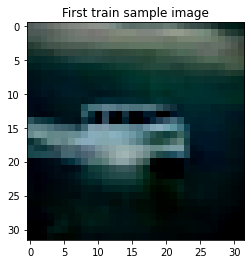

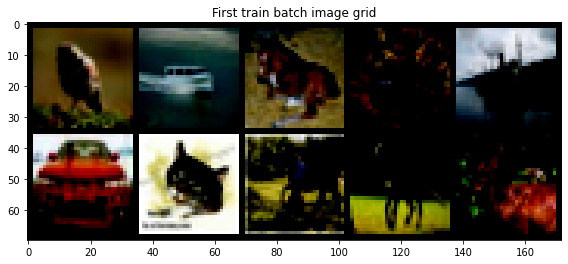

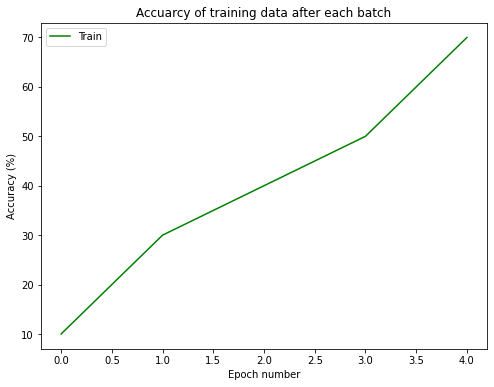

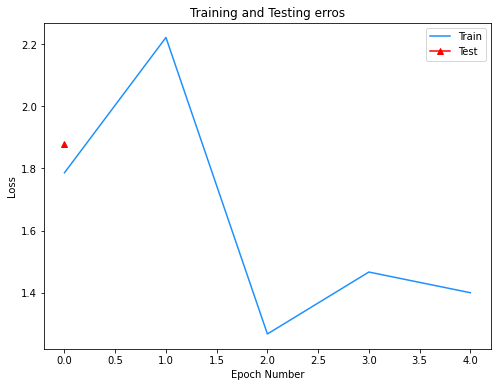

In [ ]:
#### IMPORTING LIBRARIES...

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


transformTrain = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
transformTest = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
train_data = datasets.CIFAR10(root = '/content/', train = True, transform=transformTrain, download = True)
test_data = datasets.CIFAR10(root = '/content/', train = False, transform=transformTest, download = True)


torch.manual_seed(30)
train_loader  = DataLoader(dataset = train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle = False)


def classes_sample(classes):
  pred_cls = []
  for cls in (classes):
    labels = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    pred_cls.append(labels[cls])
  return (pred_cls)


for images, classes in (train_loader):
  break

im_train_sample = images
im_classes_sample = classes

print("The shape of first train batch is: ", im_train_sample.shape)
print("The shape of first test batch is: ", im_classes_sample.shape)

plt.figure(figsize = (8,4))
plt.title("First train sample image")
plt.imshow(np.transpose(im_train_sample[1].numpy(), (1,2,0)))

plt.figure(figsize=(10,4))
plt.title("First train batch image grid")
im_grid = make_grid(im_train_sample, nrow = 5).numpy()

print("predicted classes are: ", classes_sample(im_classes_sample))
plt.imshow(np.transpose(im_grid, (1,2,0)));


class CNN_model_2(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 30, 5, 1)             
    self.conv2 = nn.Conv2d(30,60, 3, 1)
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride = 2)
    self.fc1 = nn.Linear(6*6*60, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

    torch.nn.init.kaiming_uniform_(self.conv1.weight)
    torch.nn.init.zeros_(self.conv1.bias)
    torch.nn.init.kaiming_uniform_(self.conv2.weight)
    torch.nn.init.zeros_(self.conv2.bias)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)                             #(reduces to (30,30,6))
#### MAX POOLING....                              #reduces to(15,15,6)
    x = F.relu(self.conv2(x))
    x = self.pool(x)                              # reduces to (13,13,16)
#### MAX POOLING....                              # reduces to (6,6,16)
    x = x.view(-1, 6*6*60)
    x = F.relu(self.fc1(x))
    x =  F.relu(self.fc2(x))
    x =  self.fc3(x)

    return (F.log_softmax(x, dim=1))


torch.manual_seed(30)
model = CNN_model_2()
model


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)

def GetAccuarcy(yp, yt):
  return(accuracy_score(yt, yp))


#### TRAINING....

torch.manual_seed(30)

#### SAVING ALL THE RESULTS

training_loss = []
testing_loss = []
training_accuracy = []
testing_accuracy = []
total_test_correct = 0
total_test_im = 0
epochs = 5

for i in range(epochs):

  for iter_num, (xtrain, ytrain) in enumerate(train_loader):
    iter_num+=1
    ypred = model(xtrain)                                        #forward propagation
    train_loss = criterion(ypred, ytrain)

    predicted = torch.max(ypred.data, 1)[1]
    
    train_accuracy = GetAccuarcy(predicted, ytrain)*100
 
    optimizer.zero_grad()

    train_loss.backward()                                         # Backpropagation

    optimizer.step()

    if (iter_num%1000 == 0):

      print("Epoch : {} | Loss: {} | Training accuracy : {}%".format(i, train_loss, train_accuracy))
  train_accuracy = GetAccuarcy(predicted, ytrain)*100
  training_accuracy.append(train_accuracy)
  training_loss.append(train_loss)

#### TESTING....

with torch.no_grad():
  for iter_num, (xtest, ytest) in enumerate (test_loader):

    yval = model(xtest)                                          # testing

    predicted = torch.max(yval.data, 1)[1]
    total_test_im += len(ytest)
    total_test_correct += (predicted == ytest).sum().item()
  Test_accuracy = GetAccuarcy(predicted, ytest)*100
  testing_accuracy.append(Test_accuracy)

test_loss = criterion(yval, ytest)
testing_loss.append(test_loss)
print(" ///////////   TESTING ACCURACY AFTER EPOCH: {} IS {}%\\\\\\\\\\".format(i, Test_accuracy))


plt.figure(figsize = (8,6))
plt.plot(training_accuracy, color = 'green', label = "Train")
plt.title("Accuarcy of training data after each batch")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()



plt.figure(figsize = (8,6))
plt.plot(training_loss, color = 'dodgerblue', label = "Train")
plt.plot(testing_loss, marker = "^", color = 'r', label = 'Test')
plt.title("Training and Testing erros")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()